In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

# your workspace in your drive
workspace = 'YOUR_WORKSPACE'


try:
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))
except:
  os.mkdir(os.path.join('/content/gdrive/My Drive/', workspace))
  os.chdir(os.path.join('/content/gdrive/My Drive/', workspace))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**导入相关包**

In [2]:
!pip install mxnet-cu100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from mxnet import ndarray as nd
from mxnet.gluon.data import dataset
from mxnet.gluon import nn, utils
from mxnet.gluon.nn import Dense, Activation, Conv2D, Conv2DTranspose, \
    BatchNorm, LeakyReLU, Flatten, HybridSequential, HybridBlock, Dropout
from mxnet import autograd
import numpy as np
import random
from mxnet import gluon
from random import shuffle
from datetime import datetime
import pandas as pd
import mxnet as mx
import time
import logging
from tqdm import tqdm
import argparse
from matplotlib import pyplot as plt

In [4]:
original_data = np.load('data-bin/trainingset.npy', allow_pickle=True).astype(np.float32)
length=len(original_data)
train_data,val_data=original_data[:int(length*(0.99))],original_data[int(length*(0.99)):]
test_data = np.load('data-bin/testingset.npy', allow_pickle=True).astype(np.float32)
train_data=mx.ndarray.from_numpy(train_data)
val_data=mx.ndarray.from_numpy(val_data)
test_data=mx.ndarray.from_numpy(test_data)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(138600, 64, 64, 3)
(1401, 64, 64, 3)
(19999, 64, 64, 3)


# 设定网络参数

In [5]:
def options():
    parser = argparse.ArgumentParser()
    parser.add_argument("--expname", default="OCGAN", help="Name of the experiment")
    parser.add_argument("--batch_size", default=200, type=int, help="Batch size per iteration")
    parser.add_argument("--epochs", default=50, type=int,
                        help="Number of epochs for training")
    parser.add_argument("--use_gpu", default=1, type=int,  help="1 to use GPU  ")
    parser.add_argument("--dataset", default="hw08",
                        help="Specify the training dataset  ")
    parser.add_argument("--lr", default="0.0002", type=float, help="Base learning rate")
    parser.add_argument("--ngf", default=64, type=int, help="Number of base filters in Generator")
    parser.add_argument("--ndf", default=8, type=int, help="Number of base filters in Discriminator")
    parser.add_argument("--beta1", default=0.5, type=float, help="Parameter for Adam")
    parser.add_argument("--lambda1", default=500, type=float, help="Weight of reconstruction loss")
    parser.add_argument("--img_wd", default=61, type=int, help="Image width")
    parser.add_argument("--img_ht", default=61, type=int, help="Image height")
    parser.add_argument("--continueEpochFrom", default=-1,
                        help="Continue training from specified epoch")
    parser.add_argument("--noisevar", default=0.02, type=float, help="variance of noise added to input")
    parser.add_argument("--depth", default=3, type=int, help="Number of core layers in Generator/Discriminator")
    parser.add_argument("--seed", default=-1, type=float, help="Seed generator. Use -1 for random.")
    parser.add_argument("--append", default=0, type=int, help="Append discriminator input. 1 for true")
    parser.add_argument("--classes", default="", help="Name of training class. Keep blank for random")
    parser.add_argument("--latent", default=16, type=int,  help="Dimension of the latent space.")
    parser.add_argument("--ntype", default=4, type=int, help="Novelty detector: 1 - AE 2 - ALOCC 3 - latentD 4 - OCGAN")
    parser.add_argument("--protocol", default=1, type=int, help="1 : 80/20 split, 2 : Train / Test split")
    args = parser.parse_args(args=[])
    if args.use_gpu == 1:
        args.use_gpu = True
    else:
        args.use_gpu = False
    if args.append == 1:
        args.append = True
    else:
        args.append = False
    return args

# 加载数据

In [6]:
class MyDataset(dataset.Dataset):
    def __init__(self,data,img_wd,img_ht,noisevar):
        self.data=data
        self.img_wd=img_wd
        self.img_ht=img_ht
        self.noisevar=noisevar

    def __getitem__(self, idx):
        img=self.data[idx]/ 127.5 - 1
        img_arr = mx.image.imresize(img, self.img_wd, self.img_ht)
        # Crop input and output images
        croppedimg = mx.image.fixed_crop(img_arr, 0, 0, self.img_wd, self.img_ht)
        if self.noisevar > 0:
            img_arr_in, img_arr_out = [croppedimg + mx.random.normal(0, self.noisevar, croppedimg.shape), croppedimg]
        else:
            img_arr_in, img_arr_out = [croppedimg, croppedimg]
        img_arr_in, img_arr_out = [nd.transpose(img_arr_in, (2, 0, 1)), nd.transpose(img_arr_out, (2, 0, 1))]
        return img_arr_in,img_arr_out
    def __len__(self):
        return len(self.data)

# 设定网络及模型

In [7]:
class Discriminator(HybridBlock):
    def __init__(self, in_channels, ndf=64, n_layers=3, use_sigmoid=True, use_bias=False, istest = False, isthreeway = False):
        super(Discriminator, self).__init__()

        with self.name_scope():
            self.model = HybridSequential()
            kernel_size = 5
            padding = 0 #int(np.ceil((kernel_size - 1) / 2))
            self.model.add(Conv2D(channels=ndf, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=in_channels))
            self.model.add(LeakyReLU(alpha=0.2))

            nf_mult = 1
            for n in range(1, n_layers):
                nf_mult_prev = nf_mult
                nf_mult = min(2 ** n, 8)
                self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=2,
                                      padding=padding, in_channels=ndf * nf_mult_prev,
                                      use_bias=use_bias))
                self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult , use_global_stats=istest))
                self.model.add(LeakyReLU(alpha=0.2))

            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n_layers, 8)
            self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=ndf * nf_mult_prev,
                                  use_bias=use_bias))
            self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult, use_global_stats=istest))
            self.model.add(LeakyReLU(alpha=0.2))
            self.model.add(Conv2D(channels=1, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=ndf * nf_mult))
            if isthreeway:
                self.model.add(gluon.nn.Dense(3))
            elif use_sigmoid:
                self.model.add(Activation(activation='sigmoid'))

            

    def hybrid_forward(self, F, x):
        out = self.model(x)
        #print(np.shape(out))
        return out

class LatentDiscriminator(HybridBlock):
    def __init__(self):
        super(LatentDiscriminator, self).__init__()

        with self.name_scope():
            self.model = HybridSequential()
            self.model.add(gluon.nn.Dense(128))
            self.model.add(Activation(activation='relu'))
            self.model.add(gluon.nn.Dense(64))
            self.model.add(Activation(activation='relu'))
            self.model.add(gluon.nn.Dense(16))
            self.model.add(Activation(activation='relu'))
            self.model.add(gluon.nn.Dense(1))
            self.model.add(Activation(activation='sigmoid'))
    def hybrid_forward(self, F, x):
        out = self.model(x)
        return out


class Encoder(HybridBlock):
    def __init__(self, in_channels, ndf=64, n_layers=3, use_bias=False, istest=False,latent=256, usetanh = False ):
            super(Encoder, self).__init__()
            self.model = HybridSequential()
            kernel_size = 5
            padding = 0 #int(np.ceil((kernel_size - 1) / 2))
            self.model.add(Conv2D(channels=ndf, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=in_channels))
            self.model.add(LeakyReLU(alpha=0.2))
            nf_mult = 2
            nf_mult_prev = 1

            nf_mult = 1
            for n in range(1, n_layers):
                nf_mult_prev = nf_mult
                nf_mult = 2 ** n
                self.model.add(Conv2D(channels=ndf * nf_mult, kernel_size=kernel_size, strides=2,
                                      padding=padding, in_channels=ndf * nf_mult_prev,
                                      use_bias=use_bias))
                self.model.add(BatchNorm(momentum=0.1, in_channels=ndf * nf_mult, use_global_stats=istest))
                self.model.add(LeakyReLU(alpha=0.2))

            nf_mult_prev = nf_mult
            nf_mult = 2 ** n_layers
            self.model.add(Conv2D(channels=latent, kernel_size=kernel_size, strides=2,
                                  padding=padding, in_channels=ndf * nf_mult_prev,
                                  use_bias=use_bias))
            #self.model.add(BatchNorm(momentum=0.1, in_channels =latent, use_global_stats=istest))
            if usetanh:
                self.model.add(Activation(activation='tanh'))
            else:
                self.model.add(LeakyReLU(alpha=0.2))


                     
    def hybrid_forward(self, F, x):
        out = self.model(x)
        # print(out)
        return out


class Decoder(HybridBlock):
    def __init__(self, in_channels, ndf=64, n_layers=3, use_bias=False, istest=False, latent=256, usetanh = False ):
            super(Decoder, self).__init__()
            self.model = HybridSequential()
            kernel_size = 5
            padding = 0 
            nf_mult = 2 ** n_layers
            self.model.add(Conv2DTranspose(channels=int(ndf * nf_mult/2), kernel_size=kernel_size, strides=2,
                                           padding=padding, in_channels=latent,
                                           use_bias=use_bias))
            self.model.add(BatchNorm(momentum=0.1, in_channels=int(ndf * nf_mult / 2), use_global_stats=istest))
            self.model.add(Activation(activation='relu'))
            for n in range(1, n_layers):
                nf_mult = nf_mult / 2
                self.model.add(Conv2DTranspose(channels=int(ndf * nf_mult / 2), kernel_size=kernel_size, strides=2,
                                               padding=padding, in_channels=int(ndf * nf_mult),
                                               use_bias=use_bias))
                self.model.add(BatchNorm(momentum=0.1, in_channels=int(ndf * nf_mult / 2), use_global_stats=istest))
                #self.model.add(LeakyReLU(alpha=0.2))
                if n==2:
                      self.model.add(Dropout(rate=0.5))
                self.model.add(Activation(activation='relu'))
            self.model.add(Conv2DTranspose(channels=in_channels, kernel_size=kernel_size, strides=2,
                                           padding=padding, in_channels=ndf))
            self.model.add(Activation(activation='tanh'))

    def hybrid_forward(self, F, x):
        out = self.model(x)
        # print(out)
        return out


def param_init(param, ctx):
    if param.name.find('conv') != -1:
        if param.name.find('weight') != -1:
            param.initialize(init=mx.init.Normal(0.02), ctx=ctx)
        else:
            param.initialize(init=mx.init.Zero(), ctx=ctx)
    elif param.name.find('batchnorm') != -1:
        param.initialize(init=mx.init.Zero(), ctx=ctx)
        # Initialize gamma from normal distribution with mean 1 and std 0.02
        if param.name.find('gamma') != -1:
            param.set_data(nd.random_normal(1, 0.02, param.data().shape))
    elif param.name.find('dense') != -1:
        param.initialize(init=mx.init.Normal(0.02), ctx=ctx)


def network_init(net, ctx):
    for param in net.collect_params().values():
        param_init(param, ctx)


In [11]:
def set_network(opt, ctx, istest):
    depth = opt.depth
    if istest:
        lr = 0
        beta1 = 0
    else:
        lr = opt.lr
        beta1 = opt.beta1
    ndf = opt.ndf
    ngf = opt.ngf
    latent = opt.latent
    print(latent)
    append = opt.append
    netD = None
    netD2 = None
    netDS = None
    trainerD = None
    trainerDS = None
    trainerD2 = None
    # load networks based on opt.ntype (1 - AE 2 - ALOCC 3 - latentD 4 - adnov)
    if append:
        if opt.ntype > 1:
            netD = Discriminator(in_channels=6, n_layers=2, ndf=ndf, istest=istest)
            network_init(netD, ctx=ctx)
            trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
        if opt.ntype > 2:
            netD2 = LatentDiscriminator()
            network_init(netD2, ctx=ctx)
            trainerD2 = gluon.Trainer(netD2.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
        if opt.ntype > 3:
            netDS =Discriminator(in_channels=6, n_layers=2, ndf=ngf)
            network_init(netDS, ctx=ctx)
            trainerDS = gluon.Trainer(netDS.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

    else:
        if opt.ntype > 1:
            netD = Discriminator(in_channels=3, n_layers=2, ndf=ndf, istest=istest)
            network_init(netD, ctx=ctx)
            trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
        if opt.ntype > 2:
            netD2 = LatentDiscriminator()
            network_init(netD2, ctx=ctx)
            trainerD2 = gluon.Trainer(netD2.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
        if opt.ntype > 3:
            netDS = Discriminator(in_channels=3, n_layers=2, ndf=ngf)
            network_init(netDS, ctx=ctx)
            trainerDS = gluon.Trainer(netDS.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

    netEn = Encoder(in_channels=3, n_layers=depth, latent=latent, ndf=ngf, istest=istest)
    netDe = Decoder(in_channels=3, n_layers=depth, latent=latent, ndf=ngf, istest=istest)
    network_init(netEn, ctx=ctx)
    trainerEn = gluon.Trainer(netEn.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    network_init(netDe, ctx=ctx)
    trainerDe = gluon.Trainer(netDe.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
    return netEn, netDe, netD, netD2, netDS, trainerEn, trainerDe, trainerD, trainerD2, trainerDS


# 训练

In [9]:
def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
def plotloss(loss_vec, fname):
    plt.gcf().clear()
    plt.plot(loss_vec[0], label="Dr", alpha = 0.7)
    plt.plot(loss_vec[4], label="Dl", alpha = 0.7)
    plt.plot(loss_vec[1], label="G", alpha=0.7)
    plt.plot(loss_vec[2], label="R", alpha= 0.7)
    plt.plot(loss_vec[3], label="Acc", alpha = 0.7)
    plt.legend()
    plt.show()
    plt.savefig(fname)
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')


def trainadnov(opt, train_data, val_data, ctx, networks):

    netEn = networks[0]
    netDe = networks[1]
    netD = networks[2]
    netD2 = networks[3]
    netDS = networks[4]
    trainerEn = networks[5]
    trainerDe = networks [6]
    trainerD =networks[7]
    trainerD2 = networks[8]
    trainerSD = networks[9]
    cep = opt.continueEpochFrom
    epochs = opt.epochs
    lambda1 = opt.lambda1
    batch_size = opt.batch_size
    expname = opt.expname
    append = opt.append
    text_file = open(expname + "_validtest.txt", "w")
    text_file.close()
    GAN_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
    L1_loss = gluon.loss.L2Loss()
    metric = mx.metric.CustomMetric(facc) #netD
    metricStrong = mx.metric.CustomMetric(facc) # classifier
    metric2 = mx.metric.MSE()   #netD2
    metricMSE=mx.metric.MSE()  # Encoder 和 Decoder
    loss_rec_G2 =[]
    acc2_rec = []
    loss_rec_G = []
    loss_rec_D = []
    loss_rec_R = []
    acc_rec = []
    loss_rec_D2 = []
    stamp = datetime.now().strftime('%Y_%m_%d-%H_%M')
    logging.basicConfig(level=logging.DEBUG)
    lr = 2.0 * batch_size
    logging.basicConfig(level=logging.DEBUG)
    if cep == -1:
        cep = 0
    else:
        netEn.load_params('checkpoints/' + opt.expname + '_' + str(cep) + '_En.params', ctx=ctx)
        netDe.load_params('checkpoints/' + opt.expname + '_' + str(cep) + '_De.params', ctx=ctx)
        netD.load_params('checkpoints/' + opt.expname + '_' + str(cep) + '_D.params', ctx=ctx)
        netD2.load_params('checkpoints/' + opt.expname + '_' + str(cep) + '_D2.params', ctx=ctx)
        netDS.load_params('checkpoints/' + opt.expname + '_' + str(cep) + '_SD.params', ctx=ctx)
    for epoch in range(cep + 1, epochs+1):
        tic = time.time()
        btic = time.time()
        iter = 0
        for batch in tqdm(train_data):
            ###########################
            # (1) Update D network: maximize log(D(x, y)) + log(1 - D(x, G(x, z)))
            ###########################
            real_in = batch[0].as_in_context(ctx)
            real_out =batch[1].as_in_context(ctx)
            fake_latent = netEn(real_in)
            mu = nd.random.uniform(low=-1, high=1, shape=fake_latent.shape, ctx=ctx)
            real_latent = nd.random.uniform(low=-1, high=1, shape=fake_latent.shape, ctx=ctx)
            fake_out = netDe(fake_latent)
            fake_concat = nd.concat(real_in, fake_out, dim=1) if append else fake_out
            if epoch > 150:  # negative mining
                mu = nd.random.uniform(low=-1, high=1, shape=fake_latent.shape, ctx=ctx)
                mu.attach_grad()
                for ep2 in range(1): # doing single gradient step
                    with autograd.record():
                        eps2 = nd.tanh(mu)
                        rec_output = netDS(netDe(eps2))
                        fake_label = nd.zeros(rec_output.shape, ctx=ctx)
                        errGS = GAN_loss(rec_output, fake_label)
                        errGS.backward()
                    mu -= lr / mu.shape[0] * mu.grad # Update mu with SGD
            eps2 = nd.tanh(mu)
            with autograd.record():
                # Train with fake image
                output = netD(fake_concat)# 没用
                output2 = netD2(fake_latent)
                fake_label = nd.zeros(output.shape, ctx=ctx)
                fake_latent_label = nd.zeros(output2.shape, ctx=ctx)
                eps = nd.random.uniform(low=-1, high=1, shape=fake_latent.shape, ctx=ctx)
                rec_output = netD(netDe(eps))
                errD_fake = GAN_loss(rec_output, fake_label)
                errD2_fake = GAN_loss(output2, fake_latent_label)
                metric.update([fake_label, ], [rec_output, ])
                metric2.update([fake_latent_label, ], [output2, ])
                real_concat = nd.concat(real_in, real_out, dim=1) if append else real_out
                output = netD(real_concat)
                output2 = netD2(real_latent)
                real_label = nd.ones(output.shape, ctx=ctx)
                real_latent_label = nd.ones(output2.shape, ctx=ctx)
                errD_real = GAN_loss(output, real_label)
                errD2_real = GAN_loss(output2, real_latent_label)
                errD = (errD_real + errD_fake) * 0.5
                errD2 = (errD2_real + errD2_fake) * 0.5
                totalerrD = errD + errD2
                totalerrD.backward()
                #train netD2 和 D 即 Dl Dv
                metric.update([real_label, ], [output, ])
                metric2.update([real_latent_label, ], [output2, ])
            trainerD.step(batch[0].shape[0])
            trainerD2.step(batch[0].shape[0])
            with autograd.record():
                # Train classifier
                strong_output = netDS(netDe(eps))
                strong_real = netDS(fake_concat)
                errs1 = GAN_loss(strong_output, fake_label)
                errs2 = GAN_loss(strong_real, real_label)
                metricStrong.update([fake_label, ], [strong_output, ])
                metricStrong.update([real_label, ], [strong_real, ])
                strongerr = 0.5 * (errs1 + errs2)
                strongerr.backward()
            trainerSD.step(batch[0].shape[0])
            ############################
            # (2) Update G network: maximize log(D(x, G(x, z))) - lambda1 * L1(y, G(x, z))
            ###########################
            with autograd.record():
                rec_output = netD(netDe(eps2))
                fake_latent = (netEn(real_in))
                output2 = netD2(fake_latent)
                fake_out = netDe(fake_latent)
                fake_concat = nd.concat(real_in, fake_out, dim=1) if append else fake_out
                output = netD(fake_concat)  #没用
                real_label = nd.ones(output.shape, ctx=ctx)
                real_latent_label = nd.ones(output2.shape, ctx=ctx)
                errG2 = GAN_loss(rec_output, real_label)
                errR = L1_loss(real_out, fake_out) * lambda1
                errG = 10.0 * GAN_loss(output2, real_latent_label) + errG2 + errR
                errG.backward()
            trainerDe.step(batch[0].shape[0])
            trainerEn.step(batch[0].shape[0])
            loss_rec_G2.append(nd.mean(errG2).asscalar())
            loss_rec_G.append(nd.mean(nd.mean(errG)).asscalar() - nd.mean(errG2).asscalar() - nd.mean(errR).asscalar())
            loss_rec_D.append(nd.mean(errD).asscalar())
            loss_rec_R.append(nd.mean(errR).asscalar())
            loss_rec_D2.append(nd.mean(errD2).asscalar())
            _, acc2 = metric2.get()
            name, acc = metric.get()
            acc_rec.append(acc)
            acc2_rec.append(acc2)

            # Print log infomation every ten batches
            if iter % 200 == 0:
                _, acc2 = metric2.get()
                name, acc = metric.get()
                _, accStrong = metricStrong.get()
                print('discriminator loss = %f, D2 loss = %f, generator loss = %f, G2 loss = %f, SD loss = %f,  D acc = %f , D2 acc = %f, DS acc = %f, \
                reconstruction error= %f  at iter %d epoch %d'
                    % (nd.mean(errD).asscalar(), nd.mean(errD2).asscalar(),
                    nd.mean(errG - errG2 - errR).asscalar(), nd.mean(errG2).asscalar(), nd.mean(strongerr).asscalar(), acc, acc2,
                    accStrong, nd.mean(errR).asscalar(), iter, epoch))
            iter = iter + 1
            btic = time.time()
            name, acc = metric.get()
            _, acc2 = metric2.get()
            metric.reset()
            metric2.reset()
            metricStrong.reset()

            if epoch % 10 == 0:
                filename = "checkpoints/" + expname + "_" + str(epoch) + "_D.params"
                netD.save_parameters(filename)
                filename = "checkpoints/" + expname + "_" + str(epoch) + "_D2.params"
                netD2.save_parameters(filename)
                filename = "checkpoints/" + expname + "_" + str(epoch) + "_En.params"
                netEn.save_parameters(filename)
                filename = "checkpoints/" + expname + "_" + str(epoch) + "_De.params"
                netDe.save_parameters(filename)
                filename = "checkpoints/" + expname + "_" + str(epoch) + "_SD.params"
                netDS.save_parameters(filename)
                text_file = open(expname + "_validtest.txt", "a")
                for vbatch in val_data:
                    real_in = vbatch[0].as_in_context(ctx)
                    real_out = vbatch[1].as_in_context(ctx)
                    fake_latent = netEn(real_in)
                    y = netDe(fake_latent)
                    fake_out = y
                    metricMSE.update([fake_out, ], [real_out, ])
                _, acc2 = metricMSE.get()
                text_file.write("%s %s %s %s\n" % (str(epoch), nd.mean(errR).asscalar(), str(acc2), str(accStrong)))
                metricMSE.reset()
    return [loss_rec_D, loss_rec_G, loss_rec_R, acc_rec, loss_rec_D2, loss_rec_G2, acc2_rec]

In [12]:
opt=options()
ctx = mx.gpu() if opt.use_gpu else mx.cpu()
train_dataset=MyDataset(train_data,opt.img_wd,opt.img_ht,opt.noisevar)
test_dataset=MyDataset(test_data,opt.img_wd,opt.img_ht,opt.noisevar)
val_dataset=MyDataset(val_data,opt.img_wd,opt.img_ht,opt.noisevar)
train_dataloader=gluon.data.DataLoader(train_dataset,batch_size=200,shuffle=True,last_batch='discard')
val_dataloader=gluon.data.DataLoader(val_dataset,batch_size=200,shuffle=True,last_batch='discard')
test_dataloader=gluon.data.DataLoader(test_dataset,batch_size=200,shuffle=False,last_batch='keep')
networks = set_network(opt, ctx, False)

16


In [13]:
loss_vec = trainadnov(opt, train_dataloader, val_dataloader, ctx, networks)

  0%|          | 1/693 [00:01<11:40,  1.01s/it]

discriminator loss = 0.720998, D2 loss = 0.722493, generator loss = 4.733878, G2 loss = 0.497215, SD loss = 0.734217,  D acc = 0.522500 , D2 acc = 0.247249, DS acc = 0.490000,                 reconstruction error= 113.806396  at iter 0 epoch 1


 29%|██▉       | 201/693 [01:10<02:49,  2.90it/s]

discriminator loss = 0.511295, D2 loss = 0.590851, generator loss = 6.660747, G2 loss = 0.686918, SD loss = 0.503523,  D acc = 0.997500 , D2 acc = 0.109339, DS acc = 1.000000,                 reconstruction error= 24.203344  at iter 200 epoch 1


 58%|█████▊    | 401/693 [02:17<01:40,  2.92it/s]

discriminator loss = 0.504494, D2 loss = 0.510967, generator loss = 6.877095, G2 loss = 0.691628, SD loss = 0.503379,  D acc = 1.000000 , D2 acc = 0.002335, DS acc = 1.000000,                 reconstruction error= 20.089123  at iter 400 epoch 1


 87%|████████▋ | 601/693 [03:24<00:30,  3.05it/s]

discriminator loss = 0.503629, D2 loss = 0.504414, generator loss = 6.920706, G2 loss = 0.692711, SD loss = 0.503224,  D acc = 1.000000 , D2 acc = 0.000090, DS acc = 1.000000,                 reconstruction error= 19.974207  at iter 600 epoch 1


  0%|          | 1/693 [00:00<04:10,  2.76it/s]

discriminator loss = 0.503518, D2 loss = 0.503970, generator loss = 6.924290, G2 loss = 0.692898, SD loss = 0.503239,  D acc = 1.000000 , D2 acc = 0.000040, DS acc = 1.000000,                 reconstruction error= 19.836306  at iter 0 epoch 2


 29%|██▉       | 201/693 [01:07<02:49,  2.91it/s]

discriminator loss = 0.503649, D2 loss = 0.503480, generator loss = 6.931337, G2 loss = 0.692966, SD loss = 0.503215,  D acc = 1.000000 , D2 acc = 0.000005, DS acc = 1.000000,                 reconstruction error= 19.490967  at iter 200 epoch 2


 58%|█████▊    | 401/693 [02:14<01:35,  3.05it/s]

discriminator loss = 0.503454, D2 loss = 0.503495, generator loss = 6.930625, G2 loss = 0.692774, SD loss = 0.503211,  D acc = 1.000000 , D2 acc = 0.000032, DS acc = 1.000000,                 reconstruction error= 18.597374  at iter 400 epoch 2


 87%|████████▋ | 601/693 [03:21<00:32,  2.86it/s]

discriminator loss = 0.503465, D2 loss = 0.503315, generator loss = 6.931427, G2 loss = 0.692906, SD loss = 0.503223,  D acc = 1.000000 , D2 acc = 0.000001, DS acc = 1.000000,                 reconstruction error= 19.677023  at iter 600 epoch 2


  0%|          | 1/693 [00:00<03:40,  3.14it/s]

discriminator loss = 0.503541, D2 loss = 0.503300, generator loss = 6.931437, G2 loss = 0.692835, SD loss = 0.503221,  D acc = 1.000000 , D2 acc = 0.000003, DS acc = 1.000000,                 reconstruction error= 16.581114  at iter 0 epoch 3


 29%|██▉       | 201/693 [01:07<02:52,  2.85it/s]

discriminator loss = 0.503400, D2 loss = 0.503268, generator loss = 6.931456, G2 loss = 0.692937, SD loss = 0.503209,  D acc = 1.000000 , D2 acc = 0.000001, DS acc = 1.000000,                 reconstruction error= 18.935400  at iter 200 epoch 3


 58%|█████▊    | 401/693 [02:14<01:37,  2.98it/s]

discriminator loss = 0.504391, D2 loss = 0.503240, generator loss = 6.931425, G2 loss = 0.692950, SD loss = 0.503209,  D acc = 0.997500 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.939756  at iter 400 epoch 3


 87%|████████▋ | 601/693 [03:21<00:32,  2.85it/s]

discriminator loss = 0.503466, D2 loss = 0.503233, generator loss = 6.931444, G2 loss = 0.692974, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.425686  at iter 600 epoch 3


  0%|          | 1/693 [00:00<04:04,  2.83it/s]

discriminator loss = 0.503290, D2 loss = 0.503240, generator loss = 6.931460, G2 loss = 0.693006, SD loss = 0.503216,  D acc = 1.000000 , D2 acc = 0.000001, DS acc = 1.000000,                 reconstruction error= 16.693710  at iter 0 epoch 4


 29%|██▉       | 201/693 [01:07<02:43,  3.01it/s]

discriminator loss = 0.503347, D2 loss = 0.503224, generator loss = 6.931466, G2 loss = 0.693044, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.638697  at iter 200 epoch 4


 58%|█████▊    | 401/693 [02:13<01:37,  3.01it/s]

discriminator loss = 0.503316, D2 loss = 0.503219, generator loss = 6.931471, G2 loss = 0.692949, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 18.083075  at iter 400 epoch 4


 87%|████████▋ | 601/693 [03:20<00:30,  3.03it/s]

discriminator loss = 0.503248, D2 loss = 0.503220, generator loss = 6.931471, G2 loss = 0.693066, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.940411  at iter 600 epoch 4


  0%|          | 1/693 [00:00<04:16,  2.70it/s]

discriminator loss = 0.503253, D2 loss = 0.503216, generator loss = 6.931468, G2 loss = 0.693061, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.168581  at iter 0 epoch 5


 29%|██▉       | 201/693 [01:06<02:48,  2.92it/s]

discriminator loss = 0.503245, D2 loss = 0.503214, generator loss = 6.931464, G2 loss = 0.693130, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.127996  at iter 200 epoch 5


 58%|█████▊    | 401/693 [02:13<01:35,  3.04it/s]

discriminator loss = 0.503225, D2 loss = 0.503212, generator loss = 6.931471, G2 loss = 0.693131, SD loss = 0.503266,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.752472  at iter 400 epoch 5


 87%|████████▋ | 601/693 [03:20<00:32,  2.87it/s]

discriminator loss = 0.503241, D2 loss = 0.503212, generator loss = 6.931464, G2 loss = 0.693113, SD loss = 0.503235,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.534441  at iter 600 epoch 5


  0%|          | 1/693 [00:00<03:42,  3.11it/s]

discriminator loss = 0.504282, D2 loss = 0.503211, generator loss = 6.931470, G2 loss = 0.692690, SD loss = 0.503224,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 18.030560  at iter 0 epoch 6


 29%|██▉       | 201/693 [01:06<02:45,  2.97it/s]

discriminator loss = 0.503321, D2 loss = 0.503210, generator loss = 6.931471, G2 loss = 0.693105, SD loss = 0.503219,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.531502  at iter 200 epoch 6


 58%|█████▊    | 401/693 [02:13<01:37,  3.01it/s]

discriminator loss = 0.503248, D2 loss = 0.503209, generator loss = 6.931471, G2 loss = 0.693107, SD loss = 0.503215,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.296753  at iter 400 epoch 6


 87%|████████▋ | 601/693 [03:19<00:30,  3.06it/s]

discriminator loss = 0.503232, D2 loss = 0.503208, generator loss = 6.931471, G2 loss = 0.693129, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.816385  at iter 600 epoch 6


  0%|          | 1/693 [00:00<04:14,  2.72it/s]

discriminator loss = 0.503231, D2 loss = 0.503208, generator loss = 6.931471, G2 loss = 0.693123, SD loss = 0.503227,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.612354  at iter 0 epoch 7


 29%|██▉       | 201/693 [01:06<02:41,  3.04it/s]

discriminator loss = 0.503218, D2 loss = 0.503208, generator loss = 6.931464, G2 loss = 0.693107, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.442028  at iter 200 epoch 7


 58%|█████▊    | 401/693 [02:13<01:36,  3.04it/s]

discriminator loss = 0.503228, D2 loss = 0.503207, generator loss = 6.931470, G2 loss = 0.693135, SD loss = 0.503212,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.607063  at iter 400 epoch 7


 87%|████████▋ | 601/693 [03:19<00:30,  3.06it/s]

discriminator loss = 0.503215, D2 loss = 0.503207, generator loss = 6.931471, G2 loss = 0.693139, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.004057  at iter 600 epoch 7


  0%|          | 1/693 [00:00<04:13,  2.73it/s]

discriminator loss = 0.503237, D2 loss = 0.503207, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.448395  at iter 0 epoch 8


 29%|██▉       | 201/693 [01:06<02:43,  3.00it/s]

discriminator loss = 0.503214, D2 loss = 0.503206, generator loss = 6.931471, G2 loss = 0.693139, SD loss = 0.503209,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.764227  at iter 200 epoch 8


 58%|█████▊    | 401/693 [02:12<01:33,  3.11it/s]

discriminator loss = 0.503216, D2 loss = 0.503206, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.637352  at iter 400 epoch 8


 87%|████████▋ | 601/693 [03:18<00:29,  3.16it/s]

discriminator loss = 0.503210, D2 loss = 0.503206, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.231033  at iter 600 epoch 8


  0%|          | 1/693 [00:00<03:41,  3.12it/s]

discriminator loss = 0.503217, D2 loss = 0.503206, generator loss = 6.931471, G2 loss = 0.693133, SD loss = 0.503210,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.223373  at iter 0 epoch 9


 29%|██▉       | 201/693 [01:06<02:35,  3.16it/s]

discriminator loss = 0.503214, D2 loss = 0.503206, generator loss = 6.931466, G2 loss = 0.693142, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.124586  at iter 200 epoch 9


 58%|█████▊    | 401/693 [02:12<01:32,  3.15it/s]

discriminator loss = 0.503210, D2 loss = 0.503206, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.979003  at iter 400 epoch 9


 87%|████████▋ | 601/693 [03:18<00:29,  3.13it/s]

discriminator loss = 0.503207, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693138, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.896866  at iter 600 epoch 9


  0%|          | 0/693 [00:00<?, ?it/s]

discriminator loss = 0.503210, D2 loss = 0.503206, generator loss = 6.931468, G2 loss = 0.693140, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.039007  at iter 0 epoch 10


 29%|██▉       | 200/693 [05:36<13:59,  1.70s/it]

discriminator loss = 0.503209, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.388248  at iter 200 epoch 10


 58%|█████▊    | 400/693 [11:13<08:24,  1.72s/it]

discriminator loss = 0.503213, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.563665  at iter 400 epoch 10


 87%|████████▋ | 600/693 [16:51<02:35,  1.67s/it]

discriminator loss = 0.503206, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693143, SD loss = 0.503228,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.104477  at iter 600 epoch 10


  0%|          | 1/693 [00:00<03:50,  3.00it/s]

discriminator loss = 0.503210, D2 loss = 0.503205, generator loss = 6.931470, G2 loss = 0.693145, SD loss = 0.503231,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.291035  at iter 0 epoch 11


 29%|██▉       | 201/693 [01:06<02:46,  2.96it/s]

discriminator loss = 0.503211, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503211,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.689371  at iter 200 epoch 11


 58%|█████▊    | 401/693 [02:12<01:40,  2.91it/s]

discriminator loss = 0.505178, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693034, SD loss = 0.503216,  D acc = 0.997500 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.899595  at iter 400 epoch 11


 87%|████████▋ | 601/693 [03:18<00:30,  3.04it/s]

discriminator loss = 0.503224, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.692794, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.128881  at iter 600 epoch 11


  0%|          | 1/693 [00:00<03:50,  3.00it/s]

discriminator loss = 0.503232, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693125, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.958561  at iter 0 epoch 12


 29%|██▉       | 201/693 [01:06<02:42,  3.02it/s]

discriminator loss = 0.503225, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693137, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.730101  at iter 200 epoch 12


 58%|█████▊    | 401/693 [02:12<01:38,  2.97it/s]

discriminator loss = 0.503231, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693139, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.136255  at iter 400 epoch 12


 87%|████████▋ | 601/693 [03:18<00:30,  3.07it/s]

discriminator loss = 0.503217, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.675575  at iter 600 epoch 12


  0%|          | 1/693 [00:00<03:38,  3.17it/s]

discriminator loss = 0.503209, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693116, SD loss = 0.503208,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.432724  at iter 0 epoch 13


 29%|██▉       | 201/693 [01:06<02:37,  3.13it/s]

discriminator loss = 0.503211, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693139, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.292810  at iter 200 epoch 13


 58%|█████▊    | 401/693 [02:12<01:30,  3.23it/s]

discriminator loss = 0.503206, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693141, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.910231  at iter 400 epoch 13


 87%|████████▋ | 601/693 [03:18<00:29,  3.07it/s]

discriminator loss = 0.503212, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693135, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.356030  at iter 600 epoch 13


  0%|          | 1/693 [00:00<03:33,  3.25it/s]

discriminator loss = 0.503221, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693140, SD loss = 0.503219,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.313721  at iter 0 epoch 14


 29%|██▉       | 201/693 [01:05<02:46,  2.95it/s]

discriminator loss = 0.503215, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693140, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.612324  at iter 200 epoch 14


 58%|█████▊    | 401/693 [02:10<01:37,  2.98it/s]

discriminator loss = 0.503207, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.964993  at iter 400 epoch 14


 87%|████████▋ | 601/693 [03:16<00:30,  3.03it/s]

discriminator loss = 0.503207, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.835453  at iter 600 epoch 14


  0%|          | 1/693 [00:00<03:40,  3.15it/s]

discriminator loss = 0.503209, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693143, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.784257  at iter 0 epoch 15


 29%|██▉       | 201/693 [01:06<02:45,  2.97it/s]

discriminator loss = 0.503207, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.252314  at iter 200 epoch 15


 58%|█████▊    | 401/693 [02:12<01:33,  3.14it/s]

discriminator loss = 0.503209, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.536274  at iter 400 epoch 15


 87%|████████▋ | 601/693 [03:18<00:32,  2.87it/s]

discriminator loss = 0.503207, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.477577  at iter 600 epoch 15


  0%|          | 1/693 [00:00<03:39,  3.16it/s]

discriminator loss = 0.503207, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.913824  at iter 0 epoch 16


 29%|██▉       | 201/693 [01:05<02:44,  2.99it/s]

discriminator loss = 0.503206, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693143, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.313034  at iter 200 epoch 16


 58%|█████▊    | 401/693 [02:11<01:33,  3.11it/s]

discriminator loss = 0.503206, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.383909  at iter 400 epoch 16


 87%|████████▋ | 601/693 [03:16<00:28,  3.19it/s]

discriminator loss = 0.503206, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.497279  at iter 600 epoch 16


  0%|          | 1/693 [00:00<03:50,  3.01it/s]

discriminator loss = 0.503209, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.516750  at iter 0 epoch 17


 29%|██▉       | 201/693 [01:06<02:47,  2.94it/s]

discriminator loss = 0.503205, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503208,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 17.187176  at iter 200 epoch 17


 58%|█████▊    | 401/693 [02:12<01:39,  2.94it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503208,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.511486  at iter 400 epoch 17


 87%|████████▋ | 601/693 [03:18<00:32,  2.85it/s]

discriminator loss = 0.503227, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693138, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.393783  at iter 600 epoch 17


  0%|          | 1/693 [00:00<04:09,  2.77it/s]

discriminator loss = 0.503576, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.692945, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.130355  at iter 0 epoch 18


 29%|██▉       | 201/693 [01:06<02:43,  3.01it/s]

discriminator loss = 0.503220, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693131, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.744339  at iter 200 epoch 18


 58%|█████▊    | 401/693 [02:12<01:37,  2.99it/s]

discriminator loss = 0.503215, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693127, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.244105  at iter 400 epoch 18


 87%|████████▋ | 601/693 [03:17<00:30,  3.01it/s]

discriminator loss = 0.503211, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693110, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.897582  at iter 600 epoch 18


  0%|          | 1/693 [00:00<04:08,  2.79it/s]

discriminator loss = 0.503213, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693130, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.936693  at iter 0 epoch 19


 29%|██▉       | 201/693 [01:06<02:46,  2.96it/s]

discriminator loss = 0.503215, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693136, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.770325  at iter 200 epoch 19


 58%|█████▊    | 401/693 [02:12<01:35,  3.07it/s]

discriminator loss = 0.503210, D2 loss = 0.503205, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.496288  at iter 400 epoch 19


 87%|████████▋ | 601/693 [03:17<00:29,  3.16it/s]

discriminator loss = 0.503208, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.204885  at iter 600 epoch 19


  0%|          | 0/693 [00:00<?, ?it/s]

discriminator loss = 0.503216, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503211,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.459927  at iter 0 epoch 20


 29%|██▉       | 200/693 [05:34<13:21,  1.63s/it]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.185254  at iter 200 epoch 20


 58%|█████▊    | 400/693 [11:06<08:45,  1.79s/it]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.018293  at iter 400 epoch 20


 87%|████████▋ | 600/693 [16:41<02:37,  1.70s/it]

discriminator loss = 0.503207, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.864179  at iter 600 epoch 20


  0%|          | 1/693 [00:00<04:10,  2.76it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693142, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.130880  at iter 0 epoch 21


 29%|██▉       | 201/693 [01:06<02:39,  3.09it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693141, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.007580  at iter 200 epoch 21


 58%|█████▊    | 401/693 [02:11<01:33,  3.11it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693122, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.211853  at iter 400 epoch 21


 87%|████████▋ | 601/693 [03:17<00:30,  3.01it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.619987  at iter 600 epoch 21


  0%|          | 1/693 [00:00<04:05,  2.82it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.990312  at iter 0 epoch 22


 29%|██▉       | 201/693 [01:06<02:40,  3.06it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.344069  at iter 200 epoch 22


 58%|█████▊    | 401/693 [02:11<01:34,  3.09it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.335751  at iter 400 epoch 22


 87%|████████▋ | 601/693 [03:17<00:31,  2.92it/s]

discriminator loss = 0.503207, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.217524  at iter 600 epoch 22


  0%|          | 1/693 [00:00<03:35,  3.21it/s]

discriminator loss = 0.503216, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.227856  at iter 0 epoch 23


 29%|██▉       | 201/693 [01:05<02:42,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.184027  at iter 200 epoch 23


 58%|█████▊    | 401/693 [02:10<01:34,  3.08it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.790933  at iter 400 epoch 23


 87%|████████▋ | 601/693 [03:17<00:30,  3.01it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.978412  at iter 600 epoch 23


  0%|          | 1/693 [00:00<03:51,  2.99it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.300812  at iter 0 epoch 24


 29%|██▉       | 201/693 [01:05<02:50,  2.88it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.139446  at iter 200 epoch 24


 58%|█████▊    | 401/693 [02:10<01:36,  3.04it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.828194  at iter 400 epoch 24


 87%|████████▋ | 601/693 [03:16<00:29,  3.12it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.126126  at iter 600 epoch 24


  0%|          | 1/693 [00:00<03:50,  3.00it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.574024  at iter 0 epoch 25


 29%|██▉       | 201/693 [01:05<02:34,  3.18it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.452340  at iter 200 epoch 25


 58%|█████▊    | 401/693 [02:11<01:33,  3.13it/s]

discriminator loss = 0.503208, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.349787  at iter 400 epoch 25


 87%|████████▋ | 601/693 [03:17<00:29,  3.09it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.742051  at iter 600 epoch 25


  0%|          | 1/693 [00:00<03:39,  3.16it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.268929  at iter 0 epoch 26


 29%|██▉       | 201/693 [01:05<02:35,  3.16it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.298801  at iter 200 epoch 26


 58%|█████▊    | 401/693 [02:11<01:40,  2.90it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.622284  at iter 400 epoch 26


 87%|████████▋ | 601/693 [03:16<00:30,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.568216  at iter 600 epoch 26


  0%|          | 1/693 [00:00<04:11,  2.75it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.637391  at iter 0 epoch 27


 29%|██▉       | 201/693 [01:05<02:54,  2.82it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.639681  at iter 200 epoch 27


 58%|█████▊    | 401/693 [02:12<01:35,  3.07it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.120358  at iter 400 epoch 27


 87%|████████▋ | 601/693 [03:17<00:32,  2.86it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.351236  at iter 600 epoch 27


  0%|          | 1/693 [00:00<03:35,  3.22it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.822757  at iter 0 epoch 28


 29%|██▉       | 201/693 [01:05<02:36,  3.14it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.255791  at iter 200 epoch 28


 58%|█████▊    | 401/693 [02:10<01:36,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.221663  at iter 400 epoch 28


 87%|████████▋ | 601/693 [03:16<00:29,  3.09it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.525743  at iter 600 epoch 28


  0%|          | 1/693 [00:00<03:50,  3.01it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.772091  at iter 0 epoch 29


 29%|██▉       | 201/693 [01:05<02:35,  3.16it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.536522  at iter 200 epoch 29


 58%|█████▊    | 401/693 [02:11<01:38,  2.97it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.304552  at iter 400 epoch 29


 87%|████████▋ | 601/693 [03:16<00:31,  2.93it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.560808  at iter 600 epoch 29


  0%|          | 0/693 [00:00<?, ?it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.161152  at iter 0 epoch 30


 29%|██▉       | 200/693 [05:32<13:37,  1.66s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.003452  at iter 200 epoch 30


 58%|█████▊    | 400/693 [11:04<08:23,  1.72s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.302866  at iter 400 epoch 30


 87%|████████▋ | 600/693 [16:40<02:39,  1.71s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.750245  at iter 600 epoch 30


  0%|          | 1/693 [00:00<04:05,  2.81it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.117952  at iter 0 epoch 31


 29%|██▉       | 201/693 [01:06<02:42,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.838107  at iter 200 epoch 31


 58%|█████▊    | 401/693 [02:11<01:41,  2.89it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503207,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.320606  at iter 400 epoch 31


 87%|████████▋ | 601/693 [03:16<00:29,  3.13it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.538588  at iter 600 epoch 31


  0%|          | 1/693 [00:00<04:07,  2.79it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.056003  at iter 0 epoch 32


 29%|██▉       | 201/693 [01:05<02:38,  3.11it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.985156  at iter 200 epoch 32


 58%|█████▊    | 401/693 [02:11<01:32,  3.15it/s]

discriminator loss = 0.503240, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693115, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.169411  at iter 400 epoch 32


 87%|████████▋ | 601/693 [03:16<00:30,  3.06it/s]

discriminator loss = 0.503220, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693138, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.995214  at iter 600 epoch 32


  0%|          | 1/693 [00:00<03:55,  2.93it/s]

discriminator loss = 0.503221, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.832097  at iter 0 epoch 33


 29%|██▉       | 201/693 [01:06<02:42,  3.03it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.049463  at iter 200 epoch 33


 58%|█████▊    | 401/693 [02:11<01:36,  3.04it/s]

discriminator loss = 0.503207, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693114, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.801871  at iter 400 epoch 33


 87%|████████▋ | 601/693 [03:16<00:30,  3.01it/s]

discriminator loss = 0.503211, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.548037  at iter 600 epoch 33


  0%|          | 1/693 [00:00<04:07,  2.79it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693123, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.656814  at iter 0 epoch 34


 29%|██▉       | 201/693 [01:05<02:39,  3.09it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.789468  at iter 200 epoch 34


 58%|█████▊    | 401/693 [02:10<01:32,  3.15it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.399839  at iter 400 epoch 34


 87%|████████▋ | 601/693 [03:15<00:28,  3.19it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.147869  at iter 600 epoch 34


  0%|          | 1/693 [00:00<03:51,  2.99it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.439913  at iter 0 epoch 35


 29%|██▉       | 201/693 [01:05<02:38,  3.11it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693141, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.984712  at iter 200 epoch 35


 58%|█████▊    | 401/693 [02:10<01:34,  3.11it/s]

discriminator loss = 0.503212, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.301105  at iter 400 epoch 35


 87%|████████▋ | 601/693 [03:15<00:28,  3.23it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693144, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.643196  at iter 600 epoch 35


  0%|          | 1/693 [00:00<03:35,  3.21it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693135, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.631068  at iter 0 epoch 36


 29%|██▉       | 201/693 [01:06<02:41,  3.05it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.842364  at iter 200 epoch 36


 58%|█████▊    | 401/693 [02:11<01:35,  3.07it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.841849  at iter 400 epoch 36


 87%|████████▋ | 601/693 [03:16<00:28,  3.18it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.921496  at iter 600 epoch 36


  0%|          | 1/693 [00:00<03:49,  3.01it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.915930  at iter 0 epoch 37


 29%|██▉       | 201/693 [01:05<02:38,  3.11it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.832972  at iter 200 epoch 37


 58%|█████▊    | 401/693 [02:10<01:33,  3.11it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.038033  at iter 400 epoch 37


 87%|████████▋ | 601/693 [03:15<00:30,  3.01it/s]

discriminator loss = 0.503207, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693145, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.025585  at iter 600 epoch 37


  0%|          | 1/693 [00:00<03:38,  3.17it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693139, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.427937  at iter 0 epoch 38


 29%|██▉       | 201/693 [01:05<02:37,  3.13it/s]

discriminator loss = 0.503208, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.731254  at iter 200 epoch 38


 58%|█████▊    | 401/693 [02:10<01:31,  3.19it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.965041  at iter 400 epoch 38


 87%|████████▋ | 601/693 [03:16<00:29,  3.10it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.385745  at iter 600 epoch 38


  0%|          | 1/693 [00:00<03:41,  3.13it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.871108  at iter 0 epoch 39


 29%|██▉       | 201/693 [01:05<02:39,  3.09it/s]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.293876  at iter 200 epoch 39


 58%|█████▊    | 401/693 [02:10<01:37,  3.00it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.528201  at iter 400 epoch 39


 87%|████████▋ | 601/693 [03:15<00:28,  3.23it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.044300  at iter 600 epoch 39


  0%|          | 0/693 [00:00<?, ?it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.222605  at iter 0 epoch 40


 29%|██▉       | 200/693 [05:32<13:44,  1.67s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.979910  at iter 200 epoch 40


 58%|█████▊    | 400/693 [11:04<07:54,  1.62s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693146, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.557016  at iter 400 epoch 40


 87%|████████▋ | 600/693 [16:34<02:35,  1.67s/it]

discriminator loss = 0.503206, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.681655  at iter 600 epoch 40


  0%|          | 1/693 [00:00<03:52,  2.98it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.476453  at iter 0 epoch 41


 29%|██▉       | 201/693 [01:05<02:35,  3.16it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.105415  at iter 200 epoch 41


 58%|█████▊    | 401/693 [02:10<01:38,  2.97it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.498253  at iter 400 epoch 41


 87%|████████▋ | 601/693 [03:15<00:30,  2.97it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.009932  at iter 600 epoch 41


  0%|          | 1/693 [00:00<03:31,  3.28it/s]

discriminator loss = 0.503217, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.503936  at iter 0 epoch 42


 29%|██▉       | 201/693 [01:05<02:40,  3.07it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.911208  at iter 200 epoch 42


 58%|█████▊    | 401/693 [02:09<01:34,  3.11it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.974055  at iter 400 epoch 42


 87%|████████▋ | 601/693 [03:14<00:29,  3.13it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.648853  at iter 600 epoch 42


  0%|          | 1/693 [00:00<03:35,  3.21it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.423636  at iter 0 epoch 43


 29%|██▉       | 201/693 [01:05<02:37,  3.12it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.358377  at iter 200 epoch 43


 58%|█████▊    | 401/693 [02:09<01:36,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.394842  at iter 400 epoch 43


 87%|████████▋ | 601/693 [03:14<00:30,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.030081  at iter 600 epoch 43


  0%|          | 1/693 [00:00<04:05,  2.81it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.633369  at iter 0 epoch 44


 29%|██▉       | 201/693 [01:05<02:45,  2.97it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.395635  at iter 200 epoch 44


 58%|█████▊    | 401/693 [02:10<01:34,  3.10it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.106410  at iter 400 epoch 44


 87%|████████▋ | 601/693 [03:15<00:29,  3.07it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.204088  at iter 600 epoch 44


  0%|          | 1/693 [00:00<04:04,  2.83it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.367989  at iter 0 epoch 45


 29%|██▉       | 201/693 [01:04<02:39,  3.08it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.250422  at iter 200 epoch 45


 58%|█████▊    | 401/693 [02:10<01:36,  3.03it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.204933  at iter 400 epoch 45


 87%|████████▋ | 601/693 [03:14<00:29,  3.13it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.841454  at iter 600 epoch 45


  0%|          | 1/693 [00:00<03:52,  2.98it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.322126  at iter 0 epoch 46


 29%|██▉       | 201/693 [01:05<02:33,  3.20it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.563231  at iter 200 epoch 46


 58%|█████▊    | 401/693 [02:09<01:33,  3.12it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.539768  at iter 400 epoch 46


 87%|████████▋ | 601/693 [03:14<00:30,  3.06it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.197393  at iter 600 epoch 46


  0%|          | 1/693 [00:00<04:06,  2.81it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.587092  at iter 0 epoch 47


 29%|██▉       | 201/693 [01:05<02:37,  3.12it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 16.299612  at iter 200 epoch 47


 58%|█████▊    | 401/693 [02:09<01:37,  2.99it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.262912  at iter 400 epoch 47


 87%|████████▋ | 601/693 [03:13<00:29,  3.10it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.952435  at iter 600 epoch 47


  0%|          | 1/693 [00:00<04:10,  2.76it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.413295  at iter 0 epoch 48


 29%|██▉       | 201/693 [01:05<02:33,  3.20it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.362718  at iter 200 epoch 48


 58%|█████▊    | 401/693 [02:10<01:33,  3.12it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.141930  at iter 400 epoch 48


 87%|████████▋ | 601/693 [03:15<00:32,  2.80it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503206,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.629237  at iter 600 epoch 48


  0%|          | 1/693 [00:00<03:45,  3.07it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503367,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.385000  at iter 0 epoch 49


 29%|██▉       | 201/693 [01:05<02:35,  3.16it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.491500  at iter 200 epoch 49


 58%|█████▊    | 401/693 [02:09<01:33,  3.12it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.076268  at iter 400 epoch 49


 87%|████████▋ | 601/693 [03:14<00:29,  3.08it/s]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.950606  at iter 600 epoch 49


  0%|          | 0/693 [00:00<?, ?it/s]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.651716  at iter 0 epoch 50


 29%|██▉       | 200/693 [05:26<13:04,  1.59s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.414570  at iter 200 epoch 50


 58%|█████▊    | 400/693 [11:02<07:59,  1.64s/it]

discriminator loss = 0.503204, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503205,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 15.672687  at iter 400 epoch 50


 87%|████████▋ | 600/693 [16:30<02:24,  1.56s/it]

discriminator loss = 0.503205, D2 loss = 0.503204, generator loss = 6.931471, G2 loss = 0.693147, SD loss = 0.503204,  D acc = 1.000000 , D2 acc = 0.000000, DS acc = 1.000000,                 reconstruction error= 14.956961  at iter 600 epoch 50


100%|██████████| 693/693 [19:03<00:00,  1.65s/it]


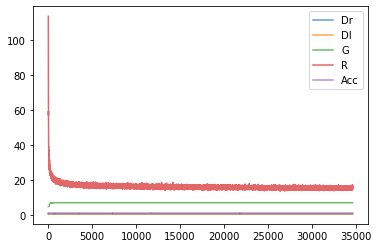

<Figure size 432x288 with 0 Axes>

In [14]:
plotloss(loss_vec, 'outputs/'+opt.expname+'_loss.png')

# Inferience

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:575: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


16
Model loading done


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


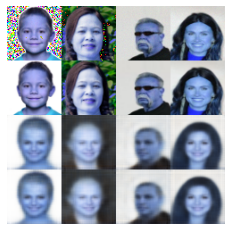

In [20]:
ctx = mx.gpu() if opt.use_gpu else mx.cpu()
networks = set_network(opt, ctx, True)
netEn = networks[0]
netDe = networks[1]
netD = networks[2]
netD2 = networks[3]
epoch=50
netEn.load_params('checkpoints/'+opt.expname+'_'+str(epoch)+'_En.params', ctx=ctx)
netDe.load_params('checkpoints/'+opt.expname+'_'+str(epoch)+'_De.params', ctx=ctx)
if opt.ntype>1:
  netD.load_params('checkpoints/'+opt.expname+'_'+str(epoch)+'_D.params', ctx=ctx)
if opt.ntype>2:
  netD2.load_params('checkpoints/'+opt.expname+'_'+str(epoch)+'_D2.params', ctx=ctx)
print('Model loading done')
scorelist1 = [];
scorelist2 = [];
scorelist3 = [];
scorelist4 = [];
count = 0
for batch in tqdm(test_dataloader):
    count = count+1
    output1=np.zeros(opt.batch_size)
    output2=np.zeros(opt.batch_size)
    output3=np.zeros(opt.batch_size)
    output4=np.zeros(opt.batch_size)
    real_in = batch[0].as_in_context(ctx)
    real_out = batch[1].as_in_context(ctx)
    outnn = (netDe(netEn((real_in))))
    output3 = nd.mean((outnn - real_out)**2, (1, 3, 2)).asnumpy()
    if opt.ntype >1: #AE
      out_concat = nd.concat(real_in, outnn, dim=1) if opt.append else outnn
      output1 = nd.mean((netD(out_concat)), (1, 3, 2)).asnumpy()
      out_concat = nd.concat(real_in, real_in, dim=1) if opt.append else real_in
      output2 = netD((out_concat))  # Image with  noise
      output2 = nd.mean(output2, (1,3,2)).asnumpy()
      out = netDe(netEn(real_out))
      out_concat =  nd.concat(real_in, out, dim=1) if opt.append else out
      output = netD(out_concat) #Denoised image
      output4 = nd.mean(output, (1, 3, 2)).asnumpy()
    scorelist1 = scorelist1+list(output1)
    scorelist2 = scorelist2+list(output2)
    scorelist3 = scorelist3+list(output3)
    scorelist4 = scorelist4+list(output4)
    out = netDe(netEn(real_in))
    # Save some sample results
    a=nd.concat(real_in[0],real_out[0], out[0], outnn[0],dim=1)
fake_img1 = nd.concat(real_in[0],real_out[0], out[0], outnn[0],dim=1)
fake_img2 = nd.concat(real_in[1],real_out[1], out[1],outnn[1], dim=1)
fake_img3 = nd.concat(real_in[2],real_out[2], out[2], outnn[2], dim=1)
fake_img4 = nd.concat(real_in[3],real_out[3],out[3],outnn[3], dim=1)
fake_img = nd.concat(fake_img1,fake_img2, fake_img3,fake_img4, dim=2)
visualize(fake_img)
out_file = 'PREDICTION_FILE_ocgan.csv'    
df = pd.DataFrame(scorelist3, columns=['Predicted'])
df.to_csv(out_file, index_label = 'Id')

In [19]:
out_file = 'PREDICTION_FILE_ocgan1.csv'    
df = pd.DataFrame(scorelist1, columns=['Predicted'])
df.to_csv(out_file, index_label = 'Id')
out_file = 'PREDICTION_FILE_ocgan2.csv'    
df = pd.DataFrame(scorelist2, columns=['Predicted'])
df.to_csv(out_file, index_label = 'Id')
out_file = 'PREDICTION_FILE_ocgan4.csv'    
df = pd.DataFrame(scorelist4, columns=['Predicted'])
df.to_csv(out_file, index_label = 'Id')